<a href="https://colab.research.google.com/github/DyatlovaA/cv-tf/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Untitled2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

# Шаг 1: Загрузка и предобработка данных

Если изображение не 224х224, то преобразуем его

Добавления шума

Загрузка и предобработка изображений

# Шаг 2: Создание автокодировщика

Кодировщик

Определение входного слоя

Сверточные слои и MaxPooling

Создание модели и вывод архитектуры

Латентное представление

Декодировщик


Создание моделей кодировщика и декодировщика

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle (4).json to kaggle (4).json


In [ ]:
pip install kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:20<00:00, 30.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, Dropout, BatchNormalization, Conv2DTranspose, GlobalAveragePooling2D, ReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2
from glob import glob
import math

In [ ]:
# Параметры
BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
NOISE_FACTOR = 0.4
EPOCHS = 20
#DATA_DIR = '/content/flower_photos/roses'  # Укажите путь к папке с изображениями
DATA_DIR = '/content/data/raw-img/cavallo'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
# Класс для работы с данными
class MyDatasetSequence(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, img_size, noise_factor):
        super().__init__()
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.noise_factor = noise_factor
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """Возвращает кортеж из (noisy_images, original_images)"""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images = np.array([self._load_image(self.image_paths[i]) for i in batch_indexes])
        noisy_images = self.add_gaussian_noise(images)
        return noisy_images, images

    def _load_image(self, path):
        """Загружает и нормализует изображение"""
        img = load_img(path, target_size=self.img_size)
        return img_to_array(img) / 255.0  # Нормализация в [0, 1]

    def add_gaussian_noise(self, images):
        """Векторизованное добавление шума"""
        noise = np.random.normal(loc=0, scale=self.noise_factor, size=images.shape)
        return np.clip(images + noise, 0., 1.)

    def __iter__(self):
        """Позволяет итерироваться по датасету"""
        for i in range(len(self)):
            yield self[i]

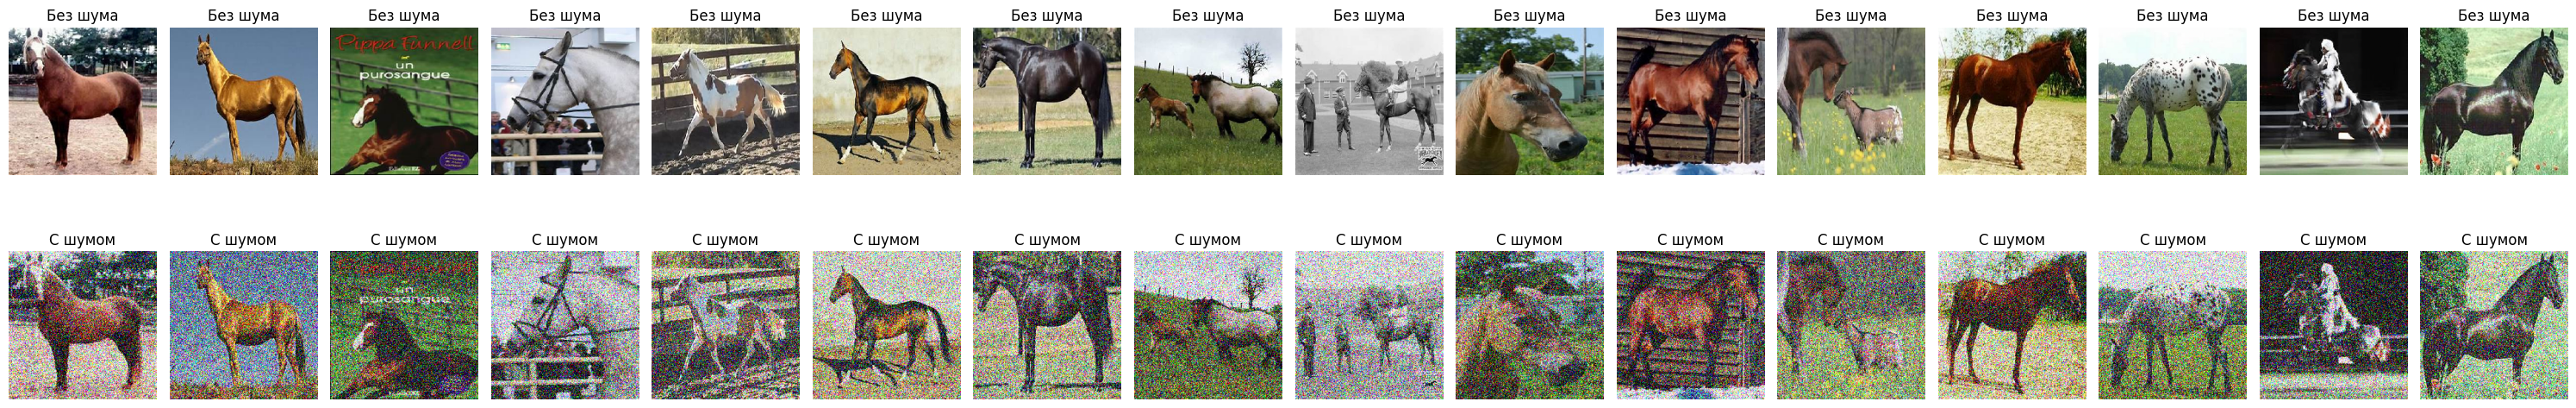

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,308,995 (4.99 MB)

 Trainable params: 1,307,203 (4.99 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/20
 29/115 ━━━━━━━━━━━━━━━━━━━━ 2:56:11 123s/step - loss: 0.0466

In [ ]:
class MyDataset:
    def __init__(
            self,
            image_path,
            batch_size=BATCH_SIZE,
            img_size=(IMG_HEIGHT, IMG_WIDTH),
            noise_factor=NOISE_FACTOR,
            train_split=0.7,
            valid_split=0.2,
            test_split=0.1
        ):
        """Создает три датасета: train, valid, test в заданных пропорциях"""
        assert math.isclose(0.7 + 0.2 + 0.1, 1.0), "Сумма train, valid, test должна быть 1"

        self.image_paths = self._get_image_paths(image_path)
        self.batch_size = batch_size
        self.img_size = img_size
        self.noise_factor = noise_factor

        # Разделение данных на train, valid, test
        random.seed(42)
        random.shuffle(self.image_paths)

        train_size = int(len(self.image_paths) * train_split)
        valid_size = int(len(self.image_paths) * valid_split)

        self.data_splits = {
            'train': MyDatasetSequence(self.image_paths[:train_size], self.batch_size, self.img_size, self.noise_factor),
            'valid': MyDatasetSequence(self.image_paths[train_size:train_size + valid_size], self.batch_size, self.img_size, self.noise_factor),
            'test': MyDatasetSequence(self.image_paths[train_size + valid_size:], self.batch_size, self.img_size, self.noise_factor)
        }

    def _get_image_paths(self, folder):
        """Читает все пути к изображениям в указанной папке"""
        exts = ('*.jpg', '*.jpeg', '*.png')  # Разрешённые расширения
        image_paths = []
        for ext in exts:
            image_paths.extend(glob(os.path.join(folder, ext)))
        if not image_paths:
            raise ValueError(f"Не найдено изображений в папке: {folder}")
        return sorted(image_paths)  # Сортируем для стабильности порядка

    def __getitem__(self, split):
        """Возвращает объект класса Sequence для train/valid/test"""
        if split not in self.data_splits:
            raise KeyError(f"Доступны только ключи: {list(self.data_splits.keys())}")
        return self.data_splits[split]

# Загрузка данных
data = MyDataset(DATA_DIR)

# Визуализация изображений
for noisy_images, original_images in data.data_splits['train']:
    fig, ax = plt.subplots(nrows=2, ncols=len(noisy_images), figsize=(30, 6))

    for idx in range(len(noisy_images)):
        original_image = original_images[idx]  # Получаем оригинальное изображение
        noisy_image = noisy_images[idx]

        # Отображаем оригинальное изображение
        ax[0, idx].imshow(original_image)
        ax[0, idx].axis('off')
        ax[0, idx].set_title('Без шума')

        # Отображаем шумное изображение
        ax[1, idx].imshow(noisy_image)
        ax[1, idx].axis('off')
        ax[1, idx].set_title('С шумом')

    plt.tight_layout()
    plt.show()
    break

# Создаем учебные и валидационные наборы
train_data = data.data_splits['train']
val_data = data.data_splits['valid']
test_data = data.data_splits['test']

# Функция для отображения изображений
def display_images(noisy, original, reconstructed, num_images=5):
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # Отображаем оригинальное изображение
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis('off')

        # Отображаем зашумленное изображение
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Отображаем восстановленное изображение
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

# Функция для оценки качества модели
def model_rate(origin_images, reconstructed_images) -> dict:
    psnr_values = []
    ssim_values = []

    for origin, reconstructed in list(zip(o_images, r_images)):
        psnr_values.append(psnr(origin, reconstructed, data_range=1.0))
        ssim_values.append(ssim(origin, reconstructed, multichannel=True, channel_axis=2, data_range=1.0))

    mean_psnr = np.mean(psnr_values)
    mean_ssim = np.mean(ssim_values)
    return {'mean_psnr': mean_psnr, 'mean_ssim': mean_ssim}

# Создание и обучение моделей автоэнкодеров
def create_autoencoder_1(input_shape):
    input_img = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((4, 4))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(4, 4))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, x)
    return autoencoder

autoencoder = create_autoencoder_1(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(train_data, validation_data=val_data,
                          epochs=EPOCHS, batch_size=BATCH_SIZE,
                          callbacks=[early_stopping], verbose=1)

# Визуализация потерь
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Тестирование модели
o_images = []
n_images = []
r_images = []

for noisy_images, original_images in test_data:
    o_images.extend(original_images)
    n_images.extend(noisy_images)
    r_images.extend(autoencoder.predict(noisy_images))

# Отображаем изображения
display_images(o_images, n_images, r_images)
metrics = model_rate(o_images, r_images)

mean_psnr = metrics['mean_psnr']
mean_ssim = metrics['mean_ssim']

print(f'Средний PNSR: {mean_psnr:.2f} дБ')
print(f'Средний SSIM: {mean_ssim:.4f}')